In [1]:
# !pip install odfpy
# !pip install fastf1


In [2]:
#IMPORTS
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = "warn" # default='warn'
import math
import itertools
import statistics
import shap

import gc

import fastf1 as ff1
from fastf1 import plotting
from fastf1.core import Laps
from fastf1 import utils
#from datetime import timedelta

#from timple.timedelta import strftimedelta
import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error, median_absolute_error


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures

from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
# import tensorflow

In [3]:
#used for initial tests
def get_acc(real, pred):
    abs_diff_list = []
    abs_diff = {"avg": 0, "<0.1": 0, "<0.25": 0, "<0.5":0, "<1": 0, ">=1": 0}
    
    proc_diff_list = []
    proc_diff = {"avg%": 0, "<0.1%":0, "<0.25%":0, "<0.5%":0, "<1%": 0, "<2.5%": 0, ">=2.5%": 0}

    total_diff = 0
    total_proc_diff = 0
    
    for i in range(len(real)):
        diff = abs(real[i]-pred[i])
          
        abs_diff_list.append(diff)
        total_diff += diff
        
        if diff < 100:
            abs_diff["<0.1"] += 1
        elif diff < 250:
            abs_diff["<0.25"] += 1
        elif diff < 500:
            abs_diff["<0.5"] += 1
        elif diff < 1000:
            abs_diff["<1"] += 1
        else:
            abs_diff[">=1"] += 1
        
        try:
            rel_diff = diff/real[i]
            total_proc_diff += rel_diff

            if rel_diff <0.001:
                proc_diff["<0.1%"]
            elif rel_diff < 0.0025:
                proc_diff["<0.25%"] += 1
            elif rel_diff < 0.005:
                proc_diff["<0.5%"] += 1
            elif rel_diff < 0.01:
                proc_diff["<1%"] += 1
            elif rel_diff < 0.025:
                proc_diff["<2.5%"] += 1
            else:
                proc_diff[">=2.5%"] += 1
        except:
            pass
    
    abs_diff["avg"]= total_diff/len(real)
    proc_diff["avg%"] = total_proc_diff/len(real)
    


    return abs_diff, proc_diff, abs_diff_list

#used for initial tests
def visualize_performance(real, pred):
    plt.figure(figsize=(10,10))
    plt.scatter(real, pred, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(pred), max(real))
    p2 = min(min(pred), min(real))
    #p1 = 10000.0
    #p2 = 100.0
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()
    
def show_predictions(X_test, y_test, prediction, difference_list):
    report_df = X_test[['Year', 'Track', 'Driver']]
    report_df['Q_time']=y_test
    report_df['Prediction']=prediction
    report_df['delta']=difference_list
    return report_df

def get_2021_Q_Results(df):
    Q_Res_df = df[["Year", "Round", "Driver", "Q_delta"]]
    Q_Res_df = Q_Res_df.dropna()

    Q_Results_2021 = {gp_name: None for gp_name in GP_names_2021}

    for gp_name in GP_names_2021:
        try:
            gp_df = Q_Res_df.loc[(df["Year"]==2021) & (Q_Res_df["Round"] == GP_names_2021.index(gp_name)+1)][["Driver", "Q_delta"]]
            Q_Results_2021[gp_name]=gp_df.sort_values(by="Q_delta", axis=0, ascending =True)
        except Exception as e:
            print(e)

    #due to heavy rain and changable conditions during the Qualifying of the Belgium Grand Prix,
    #cars that were eliminated in the early stages of the qulifying ended up setting faster laps than the ultimate
    #pole sitter, as the track got increasingly wet. Therefore, we will ignore the 2021 Belgium GP.
    Q_Results_2021["Belgium"] = None
    Q_Results_2021["Russia"] = None
    Q_Results_2021["Abu Dhabi"] = None
    return Q_Results_2021


    


In [4]:
def convert_to_ms(x):
    in_ms = None
    try:
        in_ms = int(x/pd.to_timedelta(1, unit = 'ms'))
    except:
        pass
    return in_ms

def handle_missed_session(session_name):
    data[session_name+'_time'] = None
    data[session_name+'_track_temp']= None
    data[session_name+'_tyre'] = None

#given the weekends tyre_range (1-3) and the name of the tyre (Soft, Medium, Hard)
#determines the Compound value i (for C1-C5) used
def get_compound(tyre_range, tyre_name):
    tyre = 0
    if tyre_name in ["SOFT", "MEDIUM", "HARD"]:
        if tyre_range == 1: # Range 1, 2 or 3
            if tyre_name == "SOFT":
                tyre = 3 # the corresponding Ci lable (C3 in this case)
            elif tyre_name == "MEDIUM":
                tyre = 2
            else:
                tyre = 1
        elif tyre_range == 2:
            if tyre_name == "SOFT":
                tyre = 4
            elif tyre_name == "MEDIUM":
                tyre = 3
            else:
                tyre = 2
        else:
            if tyre_name == "SOFT":
                tyre = 5
            elif tyre_name == "MEDIUM":
                tyre = 4
            else:
                tyre = 3
    else:
        if tyre_name == "INTERMEDIATE":
            tyre = -1
        elif tyre_name == "WET":
            tyre = -2
            
    return tyre

def get_weather_cond(tyre_name):
    condition= "DRY"
    if tyre_name =="INTERMEDIATE":
        condition = "INTERMEDIATE"
    elif tyre_name =="WET":
        condition = "WET"
    return condition
        

# Drivers are Qualified to participate in the Qualifying Session if they completet at least one of the
# 3 practice Sessions. In order to safe cache space, we only consider the last 2 sessions.
# returns driver Abbreviation
def get_qualified_drivers(year, GP):
    FP2_drivers = list() #create empty lists of drivers that participated in FP2/FP3
    FP3_drivers = list()
    
    try: #error handling if session didn't go ahead
        FP2 = ff1.get_session(year, GP, 'FP2')
        FP2_laps = FP2.load_laps(with_telemetry=False)
        FP2_drivers = pd.unique(FP2_laps['Driver']).tolist()
    except Exception as e:
        print(e)
        print("a")
    
    try:
        FP3 = ff1.get_session(year, GP, 'FP3')
        FP3_laps = FP3.load_laps(with_telemetry=False)
        FP3_drivers = pd.unique(FP3_laps['Driver']).tolist()
    except Exception as e:
        print(e)
        print("b")

    #list of drivers that participated in either session
    qualified_drivers = FP2_drivers
    qualified_drivers.extend(drv for drv in FP3_drivers if drv not in qualified_drivers)

    return qualified_drivers


def get_current_teamname(teamname):
    current_teamname = teamname
    if teamname == "Renault" or teamname =="Alpine F1 Team":
        current_teamname = "Alpine" 
    if teamname == "Racing Point" or teamname == "Force India":
        current_teamname = "Aston Martin"
    if teamname == "Toro Rosso":
        current_teamname = "AlphaTauri"
    if teamname =="Sauber":
        current_teamname ="Alfa Romeo"
    if teamname =="Haas F1 Team":
        current_teamname = "Haas"
        
    return current_teamname


#You have to create a cache folder in the same folder as this programm
#in order to use the cache function of FastF1. I named mine cache_folder
ff1.Cache.enable_cache('cache_folder')

Sec_times = ['T_S1_time', 'T_S2_time', 'T_S3_time']
track_temps = ['T_S1_track_temp', 'T_S2_track_temp', 'T_S3_track_temp']
air_temps = ['T_S1_air_temp', 'T_S2_air_temp', 'T_S3_air_temp']
speeds = ['T_S1_speed', 'T_S2_speed', 'T_S3_speed']
tyre_lifes = ['T_S1_tyre_life', 'T_S2_tyre_life', 'T_S3_tyre_life']

Lap_times = ['FP1_time', 'FP2_time', 'FP3_time', 'Q_time']
Lap_weather = ['FP1_weather', 'FP2_weather', 'FP3_weather', 'Q_weather']
Lap_tyre_lifes = ["FP1_tyre_life", "FP2_tyre_life", "FP3_tyre_life"]

df = pd.DataFrame(columns=['Year', 'Round', 'Track', 'Driver', 'Team',
                           'Q_delta', 'Q_track_temp', 'Q_air_temp', 'T_fastest',
                            'avg_improv', 'last_pole_time']
                        + Sec_times +Lap_times+Lap_weather+ track_temps + air_temps + speeds + tyre_lifes
                        + Lap_tyre_lifes)


#not used in final version
#import the file containing the tyre allocation for all Events 2019-2021
tyre_range_df = pd.read_csv("Tyre_range.csv") 

#tyre_range determines what compound the soft, medium and hard tyres exactly are
# i => hard, medium, soft
# 1 => C1, C2, C3 
# 2 => C2, C3, C4
# 3 => C3, C4, C5
# -1 Intermediate, -2 Wet

tyre_range = 2 #default value


tracks_2018 = ['Melbourne', 'Bahrain', 'Shanghai', 'Baku', 'Barcelona', 'Monaco', 'Montreal', 
               'Le Castellet', 'Spielberg', 'Silverstone', 'Hockenheim', 'Mogyorod', 'Spa-Francorchamps', 
               'Monza', 'Singapore', 'Sochi', 'Suzuka', 'Austin', 'Mexico City','Sao Paulo', 'Abu Dhabi']
rounds_2018 = { i : tracks_2018[i-1] for i in range(1, len(tracks_2018)+1 )}

tracks_2019 = ['Melbourne', 'Bahrain', 'Shanghai', 'Baku', 'Barcelona', 'Monaco', 'Montreal', 
               'Le Castellet', 'Spielberg', 'Silverstone', 'Hockenheim', 'Mogyorod', 'Spa-Francorchamps', 
               'Monza', 'Singapore', 'Sochi', 'Suzuka', 'Mexico City', 'Austin', 'Sao Paulo', 'Abu Dhabi']
rounds_2019 = { i : tracks_2019[i-1] for i in range(1, len(tracks_2019)+1 )}

tracks_2020 = ['Spielberg', 'Spielberg', 'Mogyorod', 'Silverstone', 'Silverstone', 'Barcelona', 
               'Spa-Francorchamps', 'Monza', 'Mugello', 'Sochi', 'Nürburg', 'Portimao', 'Imola', 'Istanbul', 
               'Bahrain', 'Bahrain Short', 'Abu Dhabi']
rounds_2020 = { i : tracks_2020[i-1] for i in range(1, len(tracks_2020)+1 )}

tracks_2021 = ['Bahrain', 'Imola', 'Portimao', 'Barcelona', 'Monaco', 'Baku', 'Le Castellet', 'Spielberg', 
               'Spielberg', 'Silverstone', 'Mogyorod', 'Spa-Francorchamps', 'Zandvoort', 'Monza', 'Sochi', 
               'Istanbul', 'Austin', 'Mexico City', 'Sao Paulo', 'Lusail', 'Jeddah', 'Abu Dhabi 2']
rounds_2021 = { i : tracks_2021[i-1] for i in range(1, len(tracks_2021)+1 ) }
GP_names_2021 = ['Bahrain', 'Emilia-Romagna', 'Portugal', 'Spain', 'Monaco', 'Azerbaijan', 'France', 'Styria', 
               'Austria', 'Britain', 'Hungary', 'Belgium', 'Netherlands', 'Italy', 'Russia', 
               'Turkey', 'USA', 'Mexico', 'Brazil', 'Qatar', 'Saudi Arabia', 'Abu Dhabi']

sprint_tracks = ["Silverstone", "Monza", "Sao Paulo"]

track_list = list(set(tracks_2018+tracks_2019+tracks_2020+tracks_2021))


tracks_test = ['Shanghai', 'Baku']
rounds_test = { i : tracks_test[i-1] for i in range(1, len(tracks_test)+1 ) }

seasons = {2018: rounds_2018, 2019: rounds_2019, 2020: rounds_2020, 2021: rounds_2021}
#seasons = {2021: rounds_2021}
#seasons = {2019: rounds_test}
sessions = ["FP1", "FP2", "FP3", "Q"]

avg_improvs = {year: {track: {"improv": 0, "Q_weather_cond": None} for track in track_list} for year in seasons}
pole_times = {year: {track: {"time": 0, "Q_weather_cond": None} for track in track_list} for year in seasons}







def update_fastest_Sectores(driver, laps): 
                                           
    try:
        fastest_S1 = convert_to_ms(laps['Sector1Time'].min())
        
        if GP_data[driver]['T_S1_time'] is None or fastest_S1 <= GP_data[driver]['T_S1_time']:
            GP_data[driver]['T_S1_time'] = fastest_S1
            

            lap = laps[laps.Sector1Time == laps['Sector1Time'].min()]

            GP_data[driver]['T_S1_track_temp'] = lap.get_weather_data()['TrackTemp'].iloc[0]
            GP_data[driver]['T_S1_air_temp'] = lap.get_weather_data()['AirTemp'].iloc[0]
            GP_data[driver]['T_S1_speed'] = lap['SpeedI1'].iloc[0]
            GP_data[driver]['T_S1_tyre_life'] = lap['TyreLife'].iloc[0]
        
    except Exception as e:
        print("fastest_S1")
        print(str(e))
        print(type(e))
        print(e.message)
    try:
        fastest_S2 = convert_to_ms(laps['Sector2Time'].min())
        
        if GP_data[driver]['T_S2_time'] is None or fastest_S2 <= GP_data[driver]['T_S2_time']:
            GP_data[driver]['T_S2_time'] = fastest_S2
            
            lap = laps[laps.Sector2Time == laps['Sector2Time'].min()]
            #lap = laps.loc[convert_to_ms(laps['Sector2Time']) == fastest_S2].iloc[0]

            GP_data[driver]['T_S2_track_temp'] = lap.get_weather_data()['TrackTemp'].iloc[0]
            GP_data[driver]['T_S2_air_temp'] = lap.get_weather_data()['AirTemp'].iloc[0]
            GP_data[driver]['T_S2_speed'] = lap['SpeedI2'].iloc[0]
            GP_data[driver]['T_S2_tyre_life'] = lap['TyreLife'].iloc[0]
    except Exception as e:
        print("fastest_S2")
        print(e)
    try:
        fastest_S3 = convert_to_ms(laps['Sector3Time'].min())
        
        if GP_data[driver]['T_S3_time'] is None or fastest_S3 <= GP_data[driver]['T_S3_time']:
            GP_data[driver]['T_S3_time'] = fastest_S3
            
            lap = laps[laps.Sector3Time == laps['Sector3Time'].min()]
            #lap = laps.loc[convert_to_ms(laps['Sector3Time']) == fastest_S3].iloc[0]

            GP_data[driver]['T_S3_track_temp'] = lap.get_weather_data()['TrackTemp'].iloc[0]
            GP_data[driver]['T_S3_air_temp'] = lap.get_weather_data()['AirTemp'].iloc[0]
            GP_data[driver]['T_S3_speed'] = lap['SpeedFL'].iloc[0]
            GP_data[driver]['T_S3_tyre_life'] = lap['TyreLife'].iloc[0]
    except Exception as e:
        print("fastest_S3")
        print(e)
    
    GP_data[driver]['T_fastest'] = GP_data[driver]['T_S1_time']+GP_data[driver]['T_S2_time']+GP_data[driver]['T_S3_time']

        
def update_avg_improvs(GP_data, year, track, Q_weather_cond): #vielleicht 107% regel enforcen?
    avg_t_fastest = 0
    avg_q_time = 0

    tot_t_fastest = 0
    tot_q_time = 0
    
    fast_num = 0
    q_time_num = 0
    
    for driver in GP_data:
        try:
            if not pd.isnull(GP_data[driver]['T_fastest']):
                tot_t_fastest += GP_data[driver]['T_fastest']
                fast_num +=1
        except Exception as e:
            print("UPDATE AVG IMPROV TOT T FASTEST ERROR", year, track)
            print(e)
            
            
        try:
            if not pd.isnull(GP_data[driver]['Q_time']):
                tot_q_time += GP_data[driver]['Q_time']
                q_time_num +=1
        except Exception as e:
            print("UPDATE AVG IMPROV TOT Q TIME ERROR", year, track)
            print(e)
    
    if fast_num>0:
        avg_t_fastest = tot_t_fastest/fast_num
    else:
        avg_t_fastest = None
    if q_time_num>0:
        avg_q_time = tot_q_time/q_time_num
    else:
        avg_q_time = None
    try:
        avg_improvs[year][track]["improv"] = avg_t_fastest-avg_q_time
        avg_improvs[year][track]["Q_weather_cond"]=Q_weather_cond
    except Exception as e:
        print("ERROR: avg_t_fastest-avg_q_time")
        print(e)
        avg_improvs[year][track] = None


def update_pole_times(GP_data, year, track, laps):
    drivers = pd.unique(laps['Driver'])
    list_fastest_laps = list()
    
    for drv in drivers:
        try:
            drvs_fastest_lap = laps.pick_driver(drv).pick_fastest()
            list_fastest_laps.append(drvs_fastest_lap)
        except:
            print(year, track)
            print("ERROR in update_pole_times!")
    try:
        fastest_laps = Laps(list_fastest_laps).sort_values(by='LapTime').reset_index(drop=True)
        pole_lap = fastest_laps.pick_fastest()
        pole_times[year][track]["time"] = convert_to_ms(pole_lap['LapTime'])
        pole_times[year][track]["Q_weather_cond"] = get_weather_cond(pole_lap["Compound"])
    except Exception as e:
        print("ERROR: pole time")
        print(e)

def set_session_weather(GP_data, session):
    compound_counter = {"WET":0, "INTERMEDIATE":0, "DRY":0}
    for driver in GP_data:
        if GP_data[driver][session+"_weather"] == "WET":
            compound_counter["WET"] +=1
        elif GP_data[driver][session+"_weather"] == "INTERMEDIATE":
            compound_counter["INTERMEDIATE"] +=1
        elif GP_data[driver][session+"_weather"] == "DRY":
            compound_counter["DRY"] += 1
    weather_cond = max(compound_counter, key = compound_counter.get)

    for driver in GP_data:
        GP_data[driver][session+"_weather"]=weather_cond
    return GP_data

    
for year in seasons:
    for GP in seasons[year]:
        track = seasons[year][GP]
       
        
        drivers = get_qualified_drivers(year, GP)
        GP_df = pd.DataFrame(columns = df.columns)
        
        GP_missed_sessions = {drv: [] for drv in drivers}
        GP_participated_sessions = {drv: [] for drv in drivers}
        
        GP_data = {drv: {key: None for key in df.columns} for drv in drivers}
        
        
        for driver in drivers:

            GP_data[driver]['Year'] = year
            GP_data[driver]['Round']= GP
            GP_data[driver]['Track'] = track
            GP_data[driver]['Driver'] = driver
            #GP_df = GP_df.append(data, ignore_index=True)
            
        
        
        for session_name in sessions: # for FP1, FP2, FP3 and Q
            #In 2021 Qualifying for the Italian, British and Brazilian GP took part direktly after FP1, as F1 tried out a new
            #"Sprint" Weekend Format. More Info on that:
            #https://www.formula1.com/en/latest/article.everything-you-need-to-know-about-the-f1-sprint-format-as-it-returns-this.6UbqdBk5NcJ2maGFiTSQv8.html#:~:text=F1%20Sprint%20is%20a%20race,without%20the%20need%20to%20pit.
            #Therefore, we do not have the data from the other two practice sessions available to make predictions
            if not ((year == 2021) and (track in sprint_tracks) and (session_name in ["FP2", "FP3"])):
                try:
                    session = ff1.get_session(year, GP, session_name)
                    laps = session.load_laps(with_telemetry=False)

                except Exception as e:
                    print(e)
                    break

                if session_name == 'Q':
                    update_pole_times(GP_data, year, track, laps)


                for driver in drivers:
                    try:
                        acc_driver_laps = laps.pick_accurate().pick_driver(driver)
                        fastest = acc_driver_laps.pick_fastest()

                        GP_data[driver][session_name+"_weather"] = get_weather_cond(fastest["Compound"])
                        GP_data[driver][session_name+"_time"] = convert_to_ms(fastest["LapTime"])

                        GP_data[driver]['Team'] = get_current_teamname(fastest['Team'])

                        if session_name != "Q":
                            update_fastest_Sectores(driver, acc_driver_laps)
                            GP_data[driver][session_name+"_tyre_life"] = fastest["TyreLife"]


                        else:
                            GP_data[driver]['Q_time'] = convert_to_ms(fastest['LapTime'])
                            GP_data[driver]['Q_delta'] = convert_to_ms(fastest['LapTime'])-pole_times[year][track]["time"]
                            GP_data[driver]['Q_track_temp'] = fastest.get_weather_data()['TrackTemp']
                            GP_data[driver]['Q_air_temp'] = fastest.get_weather_data()['AirTemp']

                        GP_participated_sessions[driver].append(session_name)

                    except Exception as e:
                        print(e)
                        print("d")
                        #handle_missed_session(session_name)
                        GP_missed_sessions[driver].append(session_name)
                        
                GP_data = set_session_weather(GP_data, session_name)
                

            
            
        #Majority vote of what the weather conditions were in Quali
        compound_counter = {"WET":0, "INTERMEDIATE":0, "DRY":0}
        for driver in GP_data:
            if GP_data[driver]["Q_weather"] == "WET":
                compound_counter["WET"] +=1
            elif GP_data[driver]["Q_weather"] == "INTERMEDIATE":
                compound_counter["INTERMEDIATE"] +=1
            elif GP_data[driver]["Q_weather"] == "DRY":
                compound_counter["DRY"] += 1
        Q_weather_cond = max(compound_counter, key = compound_counter.get)
        
        update_avg_improvs(GP_data, year, track, Q_weather_cond)#trocken training, nass quali-> avg_improv ist verschlechterung!
                                                                            #-> overflow (Spa 2021) 23days ...
        for driver in drivers:
            try:
                df = df.append(GP_data[driver], ignore_index = True)
            except Exception as e:
                    print(e)
                    print("y")
                    

core           INFO 	Loading laps for Australian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
utils          INFO 	NumExpr defaulting to 4 threads.
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  5: Lap timing integrity check failed for 2 lap(s)
core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver  9: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 14: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 27: Lap timing integrity check failed for 1 lap(s)
core        WARNING 	Driver 28: Lap timing integr

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['5', '7', '9', '33', '55', '3', '77', '44', '2', '14', '10', '28', '35', '18', '8', '16', '20', '27', '11', '31']
core           INFO 	Loading laps for Bahrain Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Bahrain Grand Prix - Practice 3 [v2.1.12]

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Bahrain Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Bahrain Grand Prix - Qualifying [v2.1.12]

api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Azerbaijan Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            IN

2018 Baku
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Spanish Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Spanish Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Spanish Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Spanish Grand Prix - Qualifying [v2.1.12]

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Monaco Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Monaco Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Canadian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Canadian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Canadian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Canadian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for French Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for French Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for French Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['77', '55', '16', '14', '5', '2', '10', '9', '11', '3', '31', '44', '7', '18', '35', '20', '28', '8', '27', '33']
core           INFO 	Loading laps for Austrian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Austrian Grand Prix - Practice 3 [v2.1.1

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Austrian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Austrian Grand Prix - Qualifying [v2.1.1

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for British Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['44', '7', '77', '5', '33', '3', '16', '20', '8', '9', '31', '11', '14', '27', '55', '18', '35', '2', '10', '28']


2018 Silverstone
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for German Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for German Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for German Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for German Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['16', '9', '35', '5', '10', '28', '27', '7', '18', '8', '20', '33', '14', '2', '3', '55', '77', '31', '11', '44']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_da

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Belgian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Belgian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Italian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Italian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Italian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Russian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Russian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

2018 Sochi
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Japanese Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Japanese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Japanese Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Japanese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for United States Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for United States Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_s

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for United States Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['5', '7', '44', '77', '33', '3', '16', '11', '55', '8', '31', '10', '20', '27', '9', '18', '35', '2', '28', '14']
core           INFO 	Loading laps for Mexican Grand Prix - Practice 2 [v2

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Mexican Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Mexican Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['33', '44', '5', '3', '7', '16', '55', '10', '9', '27', '31', '11', '8', '2', '14', '28', '35', '18', '77', '20']
core           INFO 	Loading laps for Brazilian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver 35: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77'

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Brazilian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver 35: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Brazilian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached da

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '9', '10', '11', '14', '16', '18', '20', '27', '28', '31', '33', '35', '44', '55', '77']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['2', '3', '5', '7', '8', '

api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Bahrain Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Chinese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Chinese Grand Prix - Qualifying [v2.1.1

2019 Shanghai
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Azerbaijan Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Azerbaijan Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Azerbaijan Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Azerbaijan Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['16', '5', '33', '77', '44', '26', '20', '23', '11', '7', '3', '99', '4', '55', '18', '27', '8', '88', '63', '10']
core           INFO 	Loading laps for Spanish Grand Prix - Practice 2 [v2.

core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['16', '77', '44', '33', '10', '99', '26', '20', '7', '23', '27', '3', '8', '5', '55', '4', '11', '18', '88', '63']
core           INFO 	Loading laps for Canadian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Canadian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Canadian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['5', '16', '44', '77', '33', '10', '3', '4', '11', '26', '27', '20', '55', '23', '99', '7', '8', '63', '88', '18']
core           INFO 	Loading laps for French Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for French Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for French Grand Prix - Qualifying [v2.1.12]

api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for British Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['16', '5', '44', '10', '33', '77', '4', '27', '3', '23', '99', '55', '26',

2019 Hockenheim
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_d

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['44', '33', '5', '77', '16', '10', '4', '7', '55', '20', '8', '26', '27', '11', '99', '3', '23', '63', '18', '88']
core           INFO 	Loading laps for Belgian Grand Prix - Practice 2 [v2.1

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Belgian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Belgian Grand Prix - Qualifying [v2.1.1

2019 Spa-Francorchamps
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Italian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Italian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Italian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Italian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Singapore Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Singapore Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_d

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Singapore Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['16', '44', '5', '77', '23', '33', '55', '4', '27', '3', '18', '10', '7', '11', '63', '99', '20', '8', '88', '26']
core           INFO 	Loading laps for Russian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_dat

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Japanese Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Japanese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
core           INFO 	Loading laps for Japanese Grand Prix - Practice 1 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	

No data for this session! Are you sure this session wasn't cancelled?
b


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '11', '16', '18', '20', '23', '26', '27', '33', '38', '44', '55', '63', '77', '88', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Japanese Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Japanese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...


No data for this session! Are you sure this session wasn't cancelled?
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'float' and 'NoneType'


core           INFO 	Loading laps for Mexican Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Mexican Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Mexican Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Mexican Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['16', '5', '77', '44', '55', '33', '10', '23', '4', '11', '26', '7', '18', '99', '20', '8', '63', '88', '27', '3']
core           INFO 	Loading laps for United States Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for United States Grand Prix - Practi

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for United States Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for United States Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['33', '5', '4', '77', '44', '23', '55', '7', '10', '3', '27', '18', '8', '26', '20', '99', '63', '88', '11', '16']
core           INFO 	Loading laps for Brazilian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_stat

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Brazilian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Brazilian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Brazilian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['44', '33', '16', '5', '23', '77', '26', '99', '4', '55', '7', '10', '27', '20', '3', '8', '11', '18', '63', '88']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '7', '8', '10', '11', '16', '18', '20', '23', '26', '27', '33', '44', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_d

single positional indexer is out-of-bounds
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'NoneType' and 'NoneType'


core           INFO 	Loading laps for Styrian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Styrian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
core           INFO 	Loading laps for Styrian Grand Prix - Practice 1 [v2.1.12]
api            INFO 	Using cached da

No data for this session! Are you sure this session wasn't cancelled?
b


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '40', '44', '55', '77', '88']
core           INFO 	Loading laps for Styrian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data


attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Styrian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...


No data for this session! Are you sure this session wasn't cancelled?
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'float' and 'NoneType'


core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_da

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_da

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['77', '44', '11', '16', '18', '33', '4', '5', '10', '3', '55', '23', '31', '63', '8', '20', '26', '99', '7', '6']
core           INFO 	Loading laps for British Grand Prix - Practice 2 [v2.1.1

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for British Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '16', '18', '20', '23', '26', '27', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for British Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '16', '18', '20', '23', '26', '27', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for 70th Anniversary Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '16', '18', '20', '23', '26', '27', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for 70th Anniversary Grand Prix - Qu

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Spanish Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Spanish Grand Prix - Qualifying [v2.1.12]

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Belgian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Belgian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Belgian Grand Prix - Qualifying [v2.1.12]

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Italian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Italian Grand Prix - Qualifying [v2.1.12]

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['77', '33', '44', '18', '10', '11', '16', '23', '26', '8', '31', '55', '99', '7', '20', '6', '3', '5', '4', '63']
core           INFO 	Loading laps for Russian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Russian Grand Prix - Practice 3 [v2.1.12]

No data for this session! Are you sure this session wasn't cancelled?
a


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Eifel Grand Prix - Practice 1 [v2.1.12]
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...


No data for this session! Are you sure this session wasn't cancelled?
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'NoneType' and 'NoneType'


core           INFO 	Loading laps for Portuguese Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Portuguese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_

No data for this session! Are you sure this session wasn't cancelled?
a
No data for this session! Are you sure this session wasn't cancelled?
b
No data for this session! Are you sure this session wasn't cancelled?
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'NoneType' and 'NoneType'


core           INFO 	Loading laps for Turkish Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Turkish Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['33', '16', '23', '31', '4', '5', '11', '77', '20', '18', '3', '55', '99', '10', '8', '7', '26', '63', '6', '44']
core           INFO 	Loading laps for Bahrain Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Bahrain Grand Prix - Practice 3 [v2.1.12]

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Bahrain Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Bahrain Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '8', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '55', '63', '77', '99']
core           INFO 	Loading laps for Bahrain Grand Prix - Qualifying [v2.1.12]

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Sakhir Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '10', '11', '16', '18', '20', '23', '26', '31', '33', '51', '55', '63', '77', '89', '99']
core           INFO 	Loading laps for Sakhir Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
ap

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '51', '55', '63', '77', '99']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '10', '11', '16', '18', '20', '23', '26', '31', '33', '44', '51', '55', '63', '77', '99']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Qualifying [v2

local variable 'df' referenced before assignment
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'NoneType' and 'NoneType'


core           INFO 	Loading laps for Portuguese Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Portuguese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Portuguese Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver  7: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Spanish Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Spanish Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Spanish Grand Prix - Qualifying [v2.1.12]

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Azerbaijan Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Azerbaijan Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_

2021 Baku
ERROR in update_pole_times!
2021 Baku
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for French Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for French Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for French Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for French Grand Prix - Qualifying [v2.1.12]
a

2021 Le Castellet
ERROR in update_pole_times!
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Styrian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Styrian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Styrian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Styrian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver 18: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Styrian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['44', '33', '77', '11', '22', '10', '16', '14', '18', '5', '99', '31', '55', '63', '7', '47', '3', '6', '4', '9']


attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Austrian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO

'Practice 3'
b


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for British Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.1

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Hungarian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Hungarian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_da

attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Belgian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Belgian Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d
attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Dutch Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Dutch Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '88', '99']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Dutch Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['33', '77', '44', '11', '14', '4', '18', '5', '16', '10', '3', '6', '31', '63', '99', '55', '22', '9', '88', '47']


attempt to get argmin of an empty sequence
d


core           INFO 	Loading laps for Italian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Italian Grand Prix - Practice 1 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data


'Practice 3'
b


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Italian Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '88', '99']
core           INFO 	Loading laps for Russian Grand Prix - Practice 2 [v2.1.1

No data for this session! Are you sure this session wasn't cancelled?
b


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Russian Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Russian Grand Prix - Practice 3 [v2.1.12]

No data for this session! Are you sure this session wasn't cancelled?
ERROR: avg_t_fastest-avg_q_time
unsupported operand type(s) for -: 'float' and 'NoneType'


core           INFO 	Loading laps for Turkish Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Turkish Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
a

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['10', '33', '11', '55', '16', '14', '7', '22', '77', '31', '99', '5', '47', '3', '4', '18', '9', '44', '6', '63']
core           INFO 	Loading laps for United States Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for United States Grand Prix - Practice

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Mexico City Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['11', '33', '44', '77', '55', '22', '3', '10', '16', '4', '18', '7', '99', '5', '14', '31', '63', '47', '6', '9']
core           INFO 	Loading laps for São Paulo Grand Prix - Practice 2 [v2

'Practice 3'
b


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for São Paulo Grand Prix - Qualifying [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Qatar Grand Prix - Practice 2 [v2.1.12]

api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['33', '44', '11', '22', '10', '77', '16', '55', '31', '4', '14', '99', '7', '3', '18', '63', '5', '6', '47', '9']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 2 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '

attempt to get argmin of an empty sequence
d


api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Practice 3 [v2.1.12]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['3', '4', '5', '6', '7', '9', '10', '11', '14', '16', '18', '22', '31', '33', '44', '47', '55', '63', '77', '99']
core           INFO 	Loading laps for Abu Dhabi Grand Prix - Qualifying [v2.1

In [5]:
#due to heavy rain and changable conditions during the Qualifying of the Belgium Grand Prix,
#cars that were eliminated in the early stages of the qulifying ended up setting faster laps than the ultimate
#pole sitter, as the track got increasingly wet. Therefore, we will ignore the 2021 Belgium GP.
#Abu Dhabi and Sochi get deleted as we do not have AWS predictions for those events
to_delete = [12, 22, 15]


for rnd in to_delete:
    df.loc[(df.Year==2021) & (df.Round==rnd), "Q_time"] = None
    df.loc[(df.Year==2021) & (df.Round==rnd), "Q_delta"] = None
    

pd.set_option("display.max_rows", None, "display.max_columns", None) #zeig mir alle df zeilen



In [6]:
#Attempt to directly include historical data into the instances.
#Not used in final version!


# avg_improv_over_years = {year: {track: 0 for track in track_list} for year in avg_improvs}
# total_avg_improv = {year: {track: {"improv":0, "num":0} for track in track_list} for year in avg_improvs}

# dummy_avg_improv = {year: 0 for year in avg_improvs}
# dummy_total_improv = {year: {"improv":0, "num":0} for year in avg_improvs}

        
# for year, track_dict in avg_improvs.items():
#     for track, val_dict in track_dict.items():
#         for y in avg_improvs:
#             if y>year:
#                 try:
#                     if val_dict["Q_weather_cond"] == "DRY":
#                         if (not pd.isnull(val_dict["improv"])) and (not val_dict["improv"]==0):
#                             try:

#                                 total_avg_improv[y][track]["improv"] += val_dict["improv"]
#                                 total_avg_improv[y][track]["num"] += 1
#                             except Exception as e:
#                                 print("ERROR: COULD ADD AVG_IMPROVS FOR", year,y, track)
#                                 print(e)
#                                 pass
#                 except:
#                     print("a")
#                     print("val_dict[Q_weather_cond] = None")
                    
# for year, track_dict in avg_improvs.items():
#     year_sum = 0
#     year_num = 0
#     for track, val_dict in track_dict.items():
#         try:
                        
#             if val_dict["Q_weather_cond"] == 'DRY':
#                 if val_dict["improv"] != None and val_dict["improv"] != 0:
#                     year_sum += val_dict["improv"]
#                     year_num += 1
#         except Exception as e:
#             print("b")
#             print(e)
#             print(val_dict)

    
#     for later_year in seasons:
#         if later_year > year:
#             try:
                
#                 dummy_total_improv[later_year]["improv"] += year_sum
#                 dummy_total_improv[later_year]["num"] += year_num
#             except Exception as e:
#                 print("ERROR: dummy_total_improv")
#                 print(year, track, later_year, avg_improv)
#     try:
#         dummy_avg_improv[later_year]=dummy_total_improv[later_year]["improv"]/dummy_total_improv[later_year]["num"]
#     except:
#         pass


# for year, track_dict in total_avg_improv.items():
#     for track, val_dict in track_dict.items():
#         total = 0
#         num = 0
        

#         if total_avg_improv[year][track]["num"] >0:
#             avg_improv_over_years[year][track] = total_avg_improv[year][track]["improv"]/total_avg_improv[year][track]["num"]
        
#         else:
#             avg_improv_over_years[year][track] = None

# for year in seasons:
#     for track in track_list:
#         try:                 
#             df.loc[(df['Track']==track) & (df['Year']==year), 'avg_improv'] = avg_improv_over_years[year][track]
#         except Exception as e:
#             print("ERROR: avg_improv_over_years", year, track)
#             print(e)
#             df.loc[(df['Track']==track) & (df['Year']==year), 'avg_improv'] = None
        
#         for y in reversed(range(2018, year)):
#             if (pole_times[y][track]["time"] is not None) and (pole_times[y][track]["time"]!= 0):
#                 try:
#                     if pole_times[y][track]["Q_weather_cond"] == "DRY":
#                         try:
#                             df.loc[(df['Track']==track) & (df['Year']==year), 'last_pole_time'] = pole_times[y][track]["time"]
#                         except Exception as e:
#                             print("ERROR: Last years Pole", year, track)
#                             df.loc[(df['Track']==track) & (df['Year']==year), 'last_pole_time'] = None
#                 except:
#                     pass

# df['last_pole_time'].replace({0: None}, inplace=True)
                          

In [7]:
#Quali results, ohne zb spa, sochi, abu dhabi 2021
Q_Results_2021 = get_2021_Q_Results(df)

In [8]:
df_enc = df.copy()

#le = LabelEncoder()
#le_cols = ['FP1_tyre', 'FP2_tyre', 'FP3_tyre', 'Q_tyre']

oh_cols = ['Track', 'Driver', 'Team']

oh = pd.get_dummies(data=df_enc, prefix="oh", columns = oh_cols)
df_enc = df_enc.merge(oh)
# df_enc = df_enc.drop(oh_cols, axis = 1)


driver_list = df['Driver'].unique()
oh_drivers = []
for driver in driver_list:
    try:
        oh_drivers.append('oh_'+driver)
    except:
        pass
    
team_list = df['Team'].unique()
oh_teams = []
for team in team_list:
    try: 
        oh_teams.append('oh_'+team)
    except:
        pass


track_list = df['Track'].unique()
oh_tracks = []
for track in track_list:
    oh_tracks.append('oh_'+track)

#only use GPs with dry quali, FP2, FP3, isnull in order to keep Sprint weekends
dry_df = df_enc.loc[((df_enc['Q_weather'] == "DRY")|(df_enc['Q_weather'].isnull()))  
                & ((df_enc['FP2_weather'] == "DRY")|(df_enc['FP2_weather'].isnull())) 
                & ((df_enc['FP3_weather'] == "DRY")|(df_enc['FP3_weather'].isnull()))]



In [9]:
info = ["Year", "Round", 'Driver', "Q_time"]
#creating the Feature Sets
variables_dict= {1: ["T_fastest"], 
                 2: ['FP2_time', 'FP3_time'], 
                 3: ['T_fastest', 'FP2_time', 'FP3_time'],
                 4: ['T_fastest', 'FP2_time', 'FP3_time', "FP2_tyre_life", "FP3_tyre_life"],
                 5: ['T_fastest', 'FP2_time', 'FP3_time']+oh_drivers, 
                 6: ['T_fastest', 'FP2_time', 'FP3_time']+oh_teams, 
                 7: ['T_fastest', 'FP2_time', 'FP3_time', "FP2_tyre_life", "FP3_tyre_life"]+oh_drivers, 
                 8: ['T_fastest', 'FP2_time', 'FP3_time', "FP2_tyre_life", "FP3_tyre_life"]+oh_teams,
                 9: ['T_fastest', 'FP2_time', 'FP3_time', "FP2_tyre_life", "FP3_tyre_life"]+oh_drivers+oh_tracks,
                 10: ['T_fastest', 'FP2_time', 'FP3_time', "FP2_tyre_life", "FP3_tyre_life"]+oh_teams+oh_tracks,
                 11: ['T_fastest', 'FP2_time', 'FP3_time']+oh_tracks, 
                 12: ['T_fastest', 'FP2_time', 'FP3_time', "FP2_tyre_life", "FP3_tyre_life"]+oh_tracks
               }
models = ["LinReg", "QuadReg", "CubReg", "MLPR"]

eval_dict = {(model, variables):
             {"model": None, "predicted_GPs": [], "num_pred_GPs": np.nan, "num_preds": np.nan,
              "X_train": None, "y_train": None, "X_test": None, "y_test": None, "pred_test": None, "coefs": None,
              "mod_diff_list": [], "mod_r2": np.nan, "mod_mean_abs_er": np.nan, "mod_median_abs_er": np.nan, "mod_s": np.nan, 
              "AWS_diff_list": [], "AWS_r2": np.nan, "AWS_mean_abs_er": np.nan, "AWS_median_abs_er": np.nan, "AWS_s": np.nan} 
             for (model, variables) in list(itertools.product(models, variables_dict.keys()))}

#dictionary with dfs that only contain certain variables, rows with NaN values are dropped
red_df_dict = {key: dry_df[info + variables_dict[key]].copy() for key in variables_dict.keys()}

for key in red_df_dict.keys():
    red_df_dict[key].dropna(inplace=True)
    

In [10]:
#find cardinality of training data set for each feature set
dry_count_df = dry_df[dry_df["Q_time"].notna()]
print("Number of Instances", dry_count_df.shape[0])
for key in red_df_dict.keys():
    print("Feature Set", key, "#TrainInst:", red_df_dict[key].loc[red_df_dict[key]['Year']!=2021].shape[0])

Number of Instances 1300
Feature Set 1 #TrainInst: 966
Feature Set 2 #TrainInst: 946
Feature Set 3 #TrainInst: 946
Feature Set 4 #TrainInst: 906
Feature Set 5 #TrainInst: 946
Feature Set 6 #TrainInst: 946
Feature Set 7 #TrainInst: 906
Feature Set 8 #TrainInst: 906
Feature Set 9 #TrainInst: 906
Feature Set 10 #TrainInst: 906
Feature Set 11 #TrainInst: 946
Feature Set 12 #TrainInst: 906


In [11]:
#Given Dataframe with 2021 predictions. If >=10 predictions for an event, counts as predicted.
#used for comparison to AWS predictions
def get_predicted_GPs(season_prediction):
    predicted_GPs = []
    counts = season_prediction["Round"].value_counts()
    for rnd, count in counts.items():
        if count >= 10:
            predicted_GPs.append(rnd)
    predicted_GPs.sort()
    return predicted_GPs

In [12]:
#Load 2021 AWS Qualifying Predictions
AWS_pred_dict = {GP_name: None for  GP_name in GP_names_2021}
for GP_name in GP_names_2021:
    if GP_name not in ["Russia", "Abu Dhabi"]:
        AWS_pred_dict[GP_name] = pd.read_excel(os.getcwd()+"/AWS_Predictions/"+GP_name+".ods", engine="odf",
                                                 header=None, names=["Driver", "AWS_delta"])
        AWS_pred_dict[GP_name]["AWS_delta"]=1000*AWS_pred_dict[GP_name]["AWS_delta"]
        AWS_pred_dict[GP_name]["Round"]=GP_names_2021.index(GP_name)+1




AWS_prediction = pd.DataFrame(columns = ["Round", "Driver", "AWS_delta"])

for gp_name in GP_names_2021:
    AWS_prediction = pd.concat([AWS_prediction, AWS_pred_dict[gp_name]])
    

In [13]:
cross_compair= {("LinReg", 1):None, ("QuadReg", 8):None}

# Linear Regression

In [51]:
info = ["Year", "Round", 'Driver', "Q_time"]
for key, variables in variables_dict.items():

    eval_entry = {"model": None, "predicted_GPs": [], "num_pred_GPs": np.nan, "num_preds": np.nan,
              "X_train": None, "y_train": None, "X_test": None, "y_test": None, "pred_test": None, "coefs": None,
              "mod_diff_list": [], "mod_r2": np.nan, "mod_mean_abs_er": np.nan, "mod_median_abs_er": np.nan, "mod_s": np.nan, 
              "AWS_diff_list": [], "AWS_r2": np.nan, "AWS_mean_abs_er": np.nan, "AWS_median_abs_er": np.nan, "AWS_s": np.nan} 



    X_past = red_df_dict[key].loc[red_df_dict[key]['Year']!=2021]
    X_2021 = red_df_dict[key].loc[red_df_dict[key]['Year']==2021]

    X_train_unfit = X_past.drop(['Q_time', 'Year', 'Round', 'Driver'], axis=1)
    y_train = X_past['Q_time']

    #creating the model
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train_unfit)
    feature_names = X_train_unfit.columns

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    
    
    eval_entry["coefs"] = pd.DataFrame(
        regr.coef_,
        columns=["Coefficient importance"],
        index=feature_names,
    )
    

    GP_dict_2021 = {rnd: X_2021.loc[(X_2021["Round"]==rnd), X_2021.columns] for rnd in rounds_2021}

    for rnd in GP_dict_2021:

        GP_dict_2021[rnd]["Q_delta"] = np.nan
        GP_dict_2021[rnd]["Pred_delta"] = np.nan
        GP_dict_2021[rnd]["Round"] = GP_dict_2021[rnd]["Round"].astype(dtype=int, copy=False)


        X_test = X_2021.loc[(X_2021["Round"]==rnd)].drop(info, axis=1)
        y_test= X_2021.loc[(X_2021["Round"]==rnd)]['Q_time']

        fastest_Q = y_test.min()
        GP_dict_2021[rnd]["Q_delta"] = GP_dict_2021[rnd]["Q_time"]-fastest_Q

        try:
            X_test = sc.transform(X_test)
            prediction = regr.predict(X_test)

            fastest_Pred = prediction.min()
            GP_dict_2021[rnd]["Pred_delta"]=prediction-fastest_Pred
        except:
            pass

    model_prediction = pd.DataFrame(columns = GP_dict_2021[rnd].columns)
    for rnd in GP_dict_2021:
        model_prediction = pd.concat([model_prediction, GP_dict_2021[rnd]])


    complete = pd.merge(model_prediction, AWS_prediction, how='left', on=["Round", "Driver"])
    
    #hotfix, sonst beide NaN aus mir unerklärlichen Gründen
    complete.loc[(complete.Driver =="SAI")&(complete.Round==5), "AWS_delta"]=0
    complete.loc[(complete.Driver =="HAM")&(complete.Round==13), "AWS_delta"]=0.7
    complete = complete.dropna()
    
    if key ==1:
        cross_compair[("LinReg", 1)] = complete


    real = complete["Q_delta"].tolist()
    mod_pred = complete["Pred_delta"].tolist()
    aws_pred = complete["AWS_delta"].tolist()
    
    eval_entry["model"] = regr
    eval_entry["predicted_GPs"] = get_predicted_GPs(complete)
    eval_entry["num_pred_GPs"] = len(eval_entry["predicted_GPs"])
    eval_entry["num_preds"] = complete.shape[0]
    
    eval_entry["X_train"] = X_train
    eval_entry["y_test"] = y_test
    eval_entry["X_test"] = X_test
    eval_entry["y_test"] = y_test
    eval_entry["pred_test"]= prediction
    
    eval_entry["mod_diff_list"] = [abs(r-p) for (r, p) in zip(real, mod_pred)]
    eval_entry["mod_r2"] = r2_score(real, mod_pred)
    eval_entry["mod_mean_abs_er"] = mean_absolute_error(real, mod_pred)
    eval_entry["mod_median_abs_er"] = median_absolute_error(real, mod_pred)
    eval_entry["mod_s"] = statistics.stdev(eval_entry["mod_diff_list"])

    eval_entry["AWS_diff_list"] = [abs(r-a) for (r, a) in zip(real, aws_pred)]
    eval_entry["AWS_r2"] = r2_score(real, aws_pred)
    eval_entry["AWS_mean_abs_er"] = mean_absolute_error(real, aws_pred)
    eval_entry["AWS_median_abs_er"] = median_absolute_error(real, aws_pred)
    eval_entry["AWS_s"] = statistics.stdev(eval_entry["AWS_diff_list"])

    eval_dict[("LinReg", key)] = eval_entry



# Polynomial Regression

In [15]:
info = ["Year", "Round", 'Driver', "Q_time"]
degrees = [2,3]
for deg in degrees:
    for key, variables in variables_dict.items():

        eval_entry = {"model": None, "predicted_GPs": [], "num_pred_GPs": np.nan, "num_preds": np.nan,
              "X_train": None, "y_train": None, "X_test": None, "y_test": None, "pred_test": None, "coefs": None,
              "mod_diff_list": [], "mod_r2": np.nan, "mod_mean_abs_er": np.nan, "mod_median_abs_er": np.nan, "mod_s": np.nan, 
              "AWS_diff_list": [], "AWS_r2": np.nan, "AWS_mean_abs_er": np.nan, "AWS_median_abs_er": np.nan, "AWS_s": np.nan} 



        X_past = red_df_dict[key].loc[red_df_dict[key]['Year']!=2021]
        X_2021 = red_df_dict[key].loc[red_df_dict[key]['Year']==2021]

        X_train_unfit = X_past.drop(['Q_time', 'Year', 'Round', 'Driver'], axis=1)
        y_train = X_past['Q_time']

        #creating the model
        poly = PolynomialFeatures(degree=deg)
        X_train = poly.fit_transform(X_train_unfit)

        regr = linear_model.LinearRegression()
        regr.fit(X_train, y_train)
        
        feature_names = poly.get_feature_names_out(X_train_unfit.columns)
        
        eval_entry["coefs"] = pd.DataFrame(
            regr.coef_
            * X_train.std(axis=0),
            columns=["Coefficient importance"],
            index=feature_names,
        )
        

        GP_dict_2021 = {rnd: X_2021.loc[(X_2021["Round"]==rnd), X_2021.columns] for rnd in rounds_2021}

        for rnd in GP_dict_2021:
            GP_dict_2021[rnd]["Q_delta"] = np.nan
            GP_dict_2021[rnd]["Pred_delta"] = np.nan
            GP_dict_2021[rnd]["Round"] = GP_dict_2021[rnd]["Round"].astype(dtype=int, copy=False)


            X_test = X_2021.loc[(X_2021["Round"]==rnd)].drop(info, axis=1)
            y_test= X_2021.loc[(X_2021["Round"]==rnd)]['Q_time']

            fastest_Q = y_test.min()
            GP_dict_2021[rnd]["Q_delta"] = GP_dict_2021[rnd]["Q_time"]-fastest_Q

            try:
                X_test = poly.fit_transform(X_test)
                prediction = regr.predict(X_test)

                fastest_Pred = prediction.min()
                GP_dict_2021[rnd]["Pred_delta"]=prediction-fastest_Pred
            except:
                pass

        model_prediction = pd.DataFrame(columns = GP_dict_2021[rnd].columns)
        for rnd in GP_dict_2021:
            model_prediction = pd.concat([model_prediction, GP_dict_2021[rnd]])


        complete = pd.merge(model_prediction, AWS_prediction, how='left', on=["Round", "Driver"])

        #hotfix, sonst beide NaN aus mir unerklärlichen Gründen
        complete.loc[(complete.Driver =="SAI")&(complete.Round==5), "AWS_delta"]=0
        complete.loc[(complete.Driver =="HAM")&(complete.Round==13), "AWS_delta"]=0.7
        complete = complete.dropna()
        
        if (key ==8) and (deg==2):
            cross_compair[("QuadReg", 8)] = complete

        real = complete["Q_delta"].tolist()
        mod_pred = complete["Pred_delta"].tolist()
        aws_pred = complete["AWS_delta"].tolist()

        eval_entry["model"] = regr
        eval_entry["predicted_GPs"] = get_predicted_GPs(complete)
        eval_entry["num_pred_GPs"] = len(eval_entry["predicted_GPs"])
        eval_entry["num_preds"] = complete.shape[0]
        
        eval_entry["X_train"] = X_train
        eval_entry["y_test"] = y_test
        eval_entry["X_test"] = X_test
        eval_entry["y_test"] = y_test
        eval_entry["pred_test"]= prediction

        eval_entry["mod_diff_list"] = [abs(r-p) for (r, p) in zip(real, mod_pred)]
        eval_entry["mod_r2"] = r2_score(real, mod_pred)
        eval_entry["mod_mean_abs_er"] = mean_absolute_error(real, mod_pred)
        eval_entry["mod_median_abs_er"] = median_absolute_error(real, mod_pred)
        eval_entry["mod_s"] = statistics.stdev(eval_entry["mod_diff_list"])

        eval_entry["AWS_diff_list"] = [abs(r-a) for (r, a) in zip(real, aws_pred)]
        eval_entry["AWS_r2"] = r2_score(real, aws_pred)
        eval_entry["AWS_mean_abs_er"] = mean_absolute_error(real, aws_pred)
        eval_entry["AWS_median_abs_er"] = median_absolute_error(real, aws_pred)
        eval_entry["AWS_s"] = statistics.stdev(eval_entry["AWS_diff_list"])
        
        if deg==2:
            eval_dict[("QuadReg", key)] = eval_entry
        elif deg==3:
            eval_dict[("CubReg", key)] = eval_entry


# Multilayer Perceptron Regressor

In [16]:
info = ["Year", "Round", 'Driver', "Q_time"]

for key, variables in variables_dict.items():
    print("Starting with ", "(MLPR, ", key,")")
    eval_entry = {"model": None, "predicted_GPs": [], "num_pred_GPs": np.nan, "num_preds": np.nan,
              "X_train": None, "y_train": None, "X_test": None, "y_test": None, "pred_test": None,
              "mod_diff_list": [], "mod_r2": np.nan, "mod_mean_abs_er": np.nan, "mod_median_abs_er": np.nan, "mod_s": np.nan, 
              "AWS_diff_list": [], "AWS_r2": np.nan, "AWS_mean_abs_er": np.nan, "AWS_median_abs_er": np.nan, "AWS_s": np.nan} 

    X_past = red_df_dict[key].loc[red_df_dict[key]['Year']!=2021]
    X_2021 = red_df_dict[key].loc[red_df_dict[key]['Year']==2021]

    X_train = X_past.drop(['Q_time', 'Year', 'Round', 'Driver'], axis=1)
    y_train = X_past['Q_time']

    #creating the model
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)

    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    
    
    search_space = {
        "hidden_layer_sizes": [(i,i) for i in [128, 256, 512, 1024, 1380, 1537, 2048]]+[(i,i,i) for i in [32,64, 128, 256]]+[(i,i,i,i) for i in [8,16,32]],
        "activation": ['identity'],
        "solver": ["lbfgs"],
        "alpha": [0.00001, 0.0001, 0.001, 0.01],
        "max_iter": [250,500,1000,1250,1500,1750,2000],
        "tol": [0.001, 0.0001, 0.00001]
    }

    mlpr = MLPRegressor(random_state=42)
    RS = RandomizedSearchCV(estimator=mlpr, 
                            param_distributions=search_space, 
                            cv=2,
                            n_iter=5, #TODO: Wieder auf 5 ändern!
                            scoring=["r2", "neg_median_absolute_error", "neg_mean_absolute_error"],
                            refit= "r2",
                            verbose=5)

    RS.fit(X_train, y_train)

    mlpr = RS.best_estimator_

    GP_dict_2021 = {rnd: X_2021.loc[(X_2021["Round"]==rnd), X_2021.columns] for rnd in rounds_2021}

    for rnd in GP_dict_2021:
        GP_dict_2021[rnd]["Q_delta"] = np.nan
        GP_dict_2021[rnd]["Pred_delta"] = np.nan
        GP_dict_2021[rnd]["Round"] = GP_dict_2021[rnd]["Round"].astype(dtype=int, copy=False)


        X_test = X_2021.loc[(X_2021["Round"]==rnd)].drop(info, axis=1)
        y_test= X_2021.loc[(X_2021["Round"]==rnd)]['Q_time']

        fastest_Q = y_test.min()
        GP_dict_2021[rnd]["Q_delta"] = GP_dict_2021[rnd]["Q_time"]-fastest_Q

        try:
            X_test = sc.transform(X_test)
            prediction = mlpr.predict(X_test)

            fastest_Pred = prediction.min()
            GP_dict_2021[rnd]["Pred_delta"]=prediction-fastest_Pred
        except:
            pass

    model_prediction = pd.DataFrame(columns = GP_dict_2021[rnd].columns)
    for rnd in GP_dict_2021:
        model_prediction = pd.concat([model_prediction, GP_dict_2021[rnd]])


    complete = pd.merge(model_prediction, AWS_prediction, how='left', on=["Round", "Driver"])

    #hotfix, sonst beide NaN aus mir unerklärlichen Gründen
    complete.loc[(complete.Driver =="SAI")&(complete.Round==5), "AWS_delta"]=0
    complete.loc[(complete.Driver =="HAM")&(complete.Round==13), "AWS_delta"]=0.7
    complete = complete.dropna()


    real = complete["Q_delta"].tolist()
    mod_pred = complete["Pred_delta"].tolist()
    aws_pred = complete["AWS_delta"].tolist()
    
    eval_entry["X_train"] = X_train
    eval_entry["y_test"] = y_test
    eval_entry["X_test"] = X_test
    eval_entry["y_test"] = y_test
    eval_entry["pred_test"]= prediction

    eval_entry["model"] = regr
    eval_entry["predicted_GPs"] = get_predicted_GPs(complete)
    eval_entry["num_pred_GPs"] = len(eval_entry["predicted_GPs"])
    eval_entry["num_preds"] = complete.shape[0]

    eval_entry["mod_diff_list"] = [abs(r-p) for (r, p) in zip(real, mod_pred)]
    eval_entry["mod_r2"] = r2_score(real, mod_pred)
    eval_entry["mod_mean_abs_er"] = mean_absolute_error(real, mod_pred)
    eval_entry["mod_median_abs_er"] = median_absolute_error(real, mod_pred)
    eval_entry["mod_s"] = statistics.stdev(eval_entry["mod_diff_list"])

    eval_entry["AWS_diff_list"] = [abs(r-a) for (r, a) in zip(real, aws_pred)]
    eval_entry["AWS_r2"] = r2_score(real, aws_pred)
    eval_entry["AWS_mean_abs_er"] = mean_absolute_error(real, aws_pred)
    eval_entry["AWS_median_abs_er"] = median_absolute_error(real, aws_pred)
    eval_entry["AWS_s"] = statistics.stdev(eval_entry["AWS_diff_list"])

    eval_dict[("MLPR", key)] = eval_entry




Starting with  (MLPR,  1 )
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(8, 8, 8, 8), max_iter=500, solver=lbfgs, tol=0.001; neg_mean_absolute_error: (test=-529.927) neg_median_absolute_error: (test=-391.293) r2: (test=0.994) total time=   0.0s
[CV 2/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(8, 8, 8, 8), max_iter=500, solver=lbfgs, tol=0.001; neg_mean_absolute_error: (test=-465.092) neg_median_absolute_error: (test=-369.253) r2: (test=0.997) total time=   0.0s
[CV 1/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(128, 128), max_iter=1750, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-529.927) neg_median_absolute_error: (test=-391.293) r2: (test=0.994) total time=   0.3s
[CV 2/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(128, 128), max_iter=1750, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-465.092) neg_median_absolute_error: (test=-36

[CV 2/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(16, 16, 16, 16), max_iter=500, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-448.454) neg_median_absolute_error: (test=-352.153) r2: (test=0.997) total time=   0.1s
[CV 1/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), max_iter=1500, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-585.681) neg_median_absolute_error: (test=-374.886) r2: (test=0.991) total time=   0.1s
[CV 2/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(32, 32, 32), max_iter=1500, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-448.452) neg_median_absolute_error: (test=-352.125) r2: (test=0.997) total time=   0.1s
[CV 1/2] END activation=identity, alpha=0.01, hidden_layer_sizes=(8, 8, 8, 8), max_iter=1500, solver=lbfgs, tol=0.001; neg_mean_absolute_error: (test=-585.674) neg_median_absolute_error: (test=-374.878) r2: (test=0.991) total time=   0.1s
[CV 2/2] END activation=identity, al

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(128, 128, 128), max_iter=250, solver=lbfgs, tol=0.001; neg_mean_absolute_error: (test=-1089.221) neg_median_absolute_error: (test=-372.518) r2: (test=0.877) total time=   2.3s
[CV 1/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 256, 256), max_iter=2000, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-15528.217) neg_median_absolute_error: (test=-530.157) r2: (test=-8.676) total time=   5.2s
[CV 2/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(256, 256, 256), max_iter=2000, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-2042.813) neg_median_absolute_error: (test=-370.797) r2: (test=0.288) total time=   4.2s
[CV 1/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(32, 32, 32, 32), max_iter=500, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-10695.678) neg_median_absolute_error: (test=-530.259) r2: (test=-4.022) total time=   0.1s
[CV 2/2] END activa

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/2] END activation=identity, alpha=0.01, hidden_layer_sizes=(1537, 1537), max_iter=250, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-21806.726) neg_median_absolute_error: (test=-660.514) r2: (test=-12.502) total time= 2.7min


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/2] END activation=identity, alpha=0.01, hidden_layer_sizes=(1537, 1537), max_iter=250, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-15620.783) neg_median_absolute_error: (test=-508.315) r2: (test=-7.370) total time= 2.5min


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(512, 512), max_iter=250, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-13290.809) neg_median_absolute_error: (test=-637.352) r2: (test=-4.142) total time=  19.5s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/2] END activation=identity, alpha=1e-05, hidden_layer_sizes=(512, 512), max_iter=250, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-15867.324) neg_median_absolute_error: (test=-506.470) r2: (test=-7.640) total time=  22.4s
[CV 1/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 64, 64), max_iter=500, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-19517.015) neg_median_absolute_error: (test=-634.290) r2: (test=-9.838) total time=   0.6s
[CV 2/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(64, 64, 64), max_iter=500, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-15121.544) neg_median_absolute_error: (test=-505.706) r2: (test=-7.149) total time=   0.2s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(2048, 2048), max_iter=500, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-22091.920) neg_median_absolute_error: (test=-620.541) r2: (test=-12.877) total time=10.2min
[CV 2/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(2048, 2048), max_iter=500, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-13557.721) neg_median_absolute_error: (test=-489.196) r2: (test=-5.282) total time=10.2min
Starting with  (MLPR,  11 )
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(256, 256), max_iter=1750, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-28424.394) neg_median_absolute_error: (test=-837.174) r2: (test=-16.957) total time=   3.1s
[CV 2/2] END activation=identity, alpha=0.0001, hidden_layer_sizes=(256, 256), max_iter=1750, solver=lbfgs, tol=1e-05; neg_mean_absolute_error: (test=-10970.451) neg_median_absolute_

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(32, 32, 32, 32), max_iter=250, solver=lbfgs, tol=0.001; neg_mean_absolute_error: (test=-26082.193) neg_median_absolute_error: (test=-836.985) r2: (test=-14.115) total time=   0.5s
[CV 2/2] END activation=identity, alpha=0.001, hidden_layer_sizes=(32, 32, 32, 32), max_iter=250, solver=lbfgs, tol=0.001; neg_mean_absolute_error: (test=-17980.805) neg_median_absolute_error: (test=-661.365) r2: (test=-9.333) total time=   0.4s
[CV 1/2] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 256, 256), max_iter=1000, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-26127.578) neg_median_absolute_error: (test=-837.263) r2: (test=-14.405) total time=   4.9s
[CV 2/2] END activation=identity, alpha=0.01, hidden_layer_sizes=(256, 256, 256), max_iter=1000, solver=lbfgs, tol=0.0001; neg_mean_absolute_error: (test=-11426.741) neg_median_absolute_error: (test=-661.361) r2: (test=-3.398) total time=   8.8s
Starting with 

In [62]:
evaluation = pd.DataFrame(eval_dict)
evaluation = evaluation.transpose()
evaluation = evaluation.drop(["num_pred_GPs", "coefs","model", "X_train", "y_train", "X_test", "y_test", "pred_test",
                              "AWS_diff_list", "mod_diff_list", "predicted_GPs"], axis=1)
evaluation.to_csv("evaluation.csv", sep='\t', encoding='utf-8')

evaluation

num_preds       mod_r2 mod_mean_abs_er mod_median_abs_er  \
LinReg  1        333     0.633595         387.273           296.157   
        2        270     0.537661         453.368           316.212   
        3        270     0.619894         409.218           310.725   
        4        246     0.689434         373.442           298.019   
        5        270     0.671979         393.067           298.084   
        6        270      0.65507         402.192           320.189   
        7        246     0.718778         362.409           283.828   
        8        246     0.706154          371.77           293.983   
        9        246 -2.76865e+25     4.06142e+15        5.3484e+15   
        10       246      0.70294         373.109           303.297   
        11       270     0.656846         395.374           294.312   
        12       246     0.713859         363.249            274.75   
QuadReg 1        333     0.633422         387.033           299.717   
        2        270     0.637458         395.209           284.516   
        3        270     0.627591         398.294           314.008   
        4        246     0.666555          387.38           309.857   
        5        270      -1.7792         1346.07            1325.8   
        6        270     0.701207          374.65           310.822   
        7        246     -3.18021         1596.16           1574.43   
        8        246     0.728666         355.925           293.829   
        9        246 -1.63468e+11     3.30417e+08       3.73775e+08   
        10       246     -12.6984         1903.68           750.065   
        11       270     -1.85217         911.323           414.783   
        12       246    -0.859721         844.356           569.663   
CubReg  1        333      0.63008         389.957            307.28   
        2        270     0.640705         396.408           291.715   
        3        270     0.636755          394.19           286.694   
        4        246     0.574251         423.976           321.236   
        5        270 -5.68651e+06          795283           391.642   
        6        270     0.352974         522.731           335.814   
        7        246 -5.13851e+10      1.8042e+08       1.93935e+08   
        8        246     -2.31327         1058.31           650.801   
        9        246     -880.944           19389           15750.5   
        10       246      -844711          359517           22840.2   
        11       270 -2.14014e+08     5.48752e+06           683.795   
        12       246     -942.326         13536.7            2299.1   
MLPR    1        333     0.633596         387.273           296.157   
        2        270     0.537661         453.368           316.212   
        3        270     0.619894         409.218           310.725   
        4        246     0.689434         373.442           298.018   
        5        270    -0.359763         637.686           321.211   
        6        270     0.655058         402.198            320.16   
        7        246     -8.23982         2392.61            2661.9   
        8        246     0.706154          371.77           293.982   
        9        246      0.69818         377.172           284.116   
        10       246     0.702727         373.291           303.345   
        11       270     0.656872         395.357           294.289   
        12       246      0.71392         363.207           274.613   

                  mod_s    AWS_r2 AWS_mean_abs_er AWS_median_abs_er    AWS_s  
LinReg  1       392.679  0.703128          355.31               276   346.69  
        2       447.414  0.695333         370.501               277  360.666  
        3        407.56  0.695333         370.501               277  360.666  
        4       326.278  0.702697         364.904               274  319.783  
        5       365.128  0.695333         370.501               277  360.666  
        6       375.368  0.695333         370.501        

In [19]:
#Find out the coefficient for the transformation from "T_fastest" to predicted Quali time
key = 1
variables = ["T_fastest"]

X_past = red_df_dict[key].loc[red_df_dict[key]['Year']!=2021]
X_2021 = red_df_dict[key].loc[red_df_dict[key]['Year']==2021]

X_train = X_past.drop(['Q_time', 'Year', 'Round', 'Driver'], axis=1)
y_train = X_past['Q_time']

#creating the model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

regr.coef_

array([0.98709485])

In [20]:
#comparison between LR1, QR8 and MLPR12 on same instances
joined = pd.merge(cross_compair[("LinReg", 1)], cross_compair[("QuadReg", 8)], how='left', on=["Round", "Driver"])
joined = joined.dropna()


LR1_comp = {}
real = joined["Q_delta_x"].tolist()
mod_pred = joined["Pred_delta_x"].tolist()
LR1_comp["mod_diff_list"] = [abs(r-p) for (r, p) in zip(real, mod_pred)]
LR1_comp["mod_r2"] = r2_score(real, mod_pred)
LR1_comp["mod_median_abs_er"] = median_absolute_error(real, mod_pred)
LR1_comp["mod_mean_abs_er"] = mean_absolute_error(real, mod_pred)
LR1_comp["mod_s"] = statistics.stdev(LR1_comp["mod_diff_list"])



# Evaluation

In [ ]:
#The only difference in variables between 8 and 12 is the use of the driver/the track.
#As those variables are available for every single entry in the dataset,
#models based on set 8 and 12 make predictions for the same datasets

In [21]:
evaluation_copy = evaluation.copy()
eval_dict_copy = eval_dict.copy()

# Create Boxplots

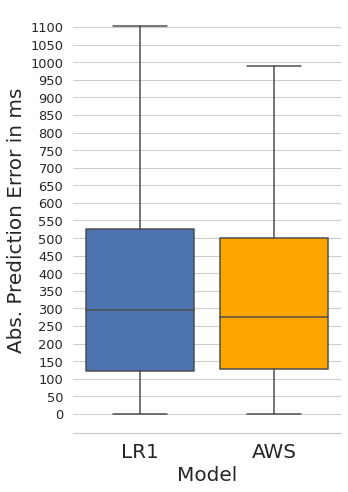

0.7031 128.0 276.0 501.0 355.31 346.69
0.6336 120.93696213584917 296.1569995147438 526.3958387377643 387.27 392.68


In [22]:
evaluation_copy = evaluation.copy()
eval_dict_copy = eval_dict.copy()

key = ("LinReg", 1)

df1 = pd.DataFrame(list(zip(eval_dict_copy[key]["mod_diff_list"],
                                         eval_dict_copy[key]["AWS_diff_list"])),
                   columns = ["model_diff", "aws_diff"])




sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(5,7))

g = sns.boxplot(data=df1, orient = "v", showfliers = False)

plt.xlabel('Model', fontsize=20)
plt.ylabel('Abs. Prediction Error in ms', fontsize=20)

xvalues = ["LR1", "AWS"]
# set xvalues as xtick values
plt.xticks(np.arange(2), xvalues, fontsize=20)

yint = [i for i in range(0,1150, 50)]
plt.yticks(yint, fontsize=13)

# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)


palette= ['b', 'orange']
color_dict = dict(zip(xvalues, palette))
for i in range(0,2):
    mybox = g.artists[i]
    mybox.set_facecolor(color_dict[xvalues[i]])



# Text p1
mod_mean = round(eval_dict_copy[key]["mod_mean_abs_er"],2)
mod_r2 = round(eval_dict_copy[key]["mod_r2"],4)
#mod_me = round(max(eval_dict_copy[key]["mod_diff_list"]),2)
mod_s = round(eval_dict_copy[key]["mod_s"],2)
mod_med = round(np.percentile(eval_dict_copy[key]["mod_diff_list"], [50])[0],2)

mod_lp = np.percentile(eval_dict_copy[key]["mod_diff_list"], [25])[0]
mod_med = np.percentile(eval_dict_copy[key]["mod_diff_list"], [50])[0]
mod_up = np.percentile(eval_dict_copy[key]["mod_diff_list"], [75])[0]



# mod_textstr = r"$\tilde{x}$" + f" = {mod_med}\n"+"$\overline {x}$" + f" = {mod_mean} \ns = {mod_s} \nR² = {mod_r2}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
# g.text(-0.16, (np.percentile(eval_dict_copy[key]["mod_diff_list"], [54])),
#        mod_textstr, fontsize=20, bbox=props)

# Text p2
aws_mean = round(eval_dict_copy[key]["AWS_mean_abs_er"],2)
aws_r2 = round(eval_dict_copy[key]["AWS_r2"],4)
#aws_me = round(max(eval_dict_copy[key]["AWS_diff_list"]),2)
aws_s = round(eval_dict_copy[key]["AWS_s"],2)

aws_lp = np.percentile(eval_dict_copy[key]["AWS_diff_list"], [25])[0]
aws_med = np.percentile(eval_dict_copy[key]["AWS_diff_list"], [50])[0]
aws_up = np.percentile(eval_dict_copy[key]["AWS_diff_list"], [75])[0]

# aws_textstr = "$\overline {x}$" + f" = {aws_mean} \ns = {aws_s} \nR² = {aws_r2}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
# g.text(1-0.15, (np.percentile(eval_dict_copy[key]["mod_diff_list"], [54])),
#        aws_textstr, fontsize=20, bbox=props)


    
plt.tight_layout()
plt.savefig('LR1_boxplot.pdf', dpi=1000)
plt.show()
print(aws_r2, aws_lp, aws_med, aws_up, aws_mean, aws_s)
print(mod_r2, mod_lp, mod_med, mod_up, mod_mean, mod_s)


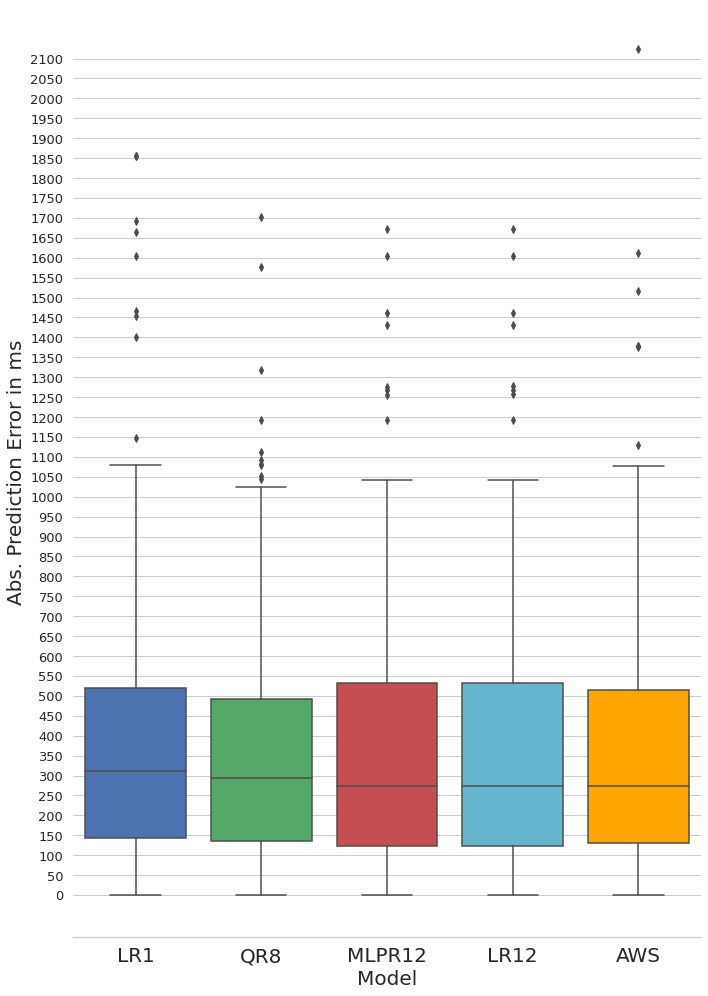

r2, lp, median, up, mean, s
0.7027 131.0 274.0 515.75 364.9 319.78
0.6833 144.2342405339714 310.5297061164747 518.692657087282 380.49 336.13
0.7287 136.0784857707331 293.82863967260346 492.49581490366836 355.92 296.9
0.7139 123.77539111267106 274.61278872854746 532.876943719355 363.21 307.56
0.7139 123.9375 274.75 532.6875 363.25 307.59


In [26]:
key_qr = ("QuadReg", 8)
key_mlpr = ("MLPR", 12)
key_lr = ("LinReg", 12)

df2 = pd.DataFrame(list(zip(LR1_comp["mod_diff_list"], eval_dict_copy[key_qr]["mod_diff_list"],
                            eval_dict_copy[key_mlpr]["mod_diff_list"], eval_dict_copy[key_lr]["mod_diff_list"],
                                         eval_dict_copy[key_qr]["AWS_diff_list"])),
                   columns = ["LR1_diff", "QuadReg_diff", "MLPR_diff", "LR12_diff", "aws_diff"])




sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(10,14))

g = sns.boxplot(data=df2, orient = "v", showfliers = True)

plt.xlabel('Model', fontsize=20)
plt.ylabel('Abs. Prediction Error in ms', fontsize=20)

xvalues = ["LR1", "QR8", "MLPR12", "LR12", "AWS"]
# set xvalues as xtick values
plt.xticks(np.arange(5), xvalues, fontsize=20)

yint = [i for i in range(0,2150, 50)]
plt.yticks(yint, fontsize=13)

# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)


palette= ['b', 'g', 'r', 'c', 'orange']
color_dict = dict(zip(xvalues, palette))
for i in range(0,5):
    mybox = g.artists[i]
    mybox.set_facecolor(color_dict[xvalues[i]])


### Provide mean and standard deviation for each model###
# Text LinReg
lr_mean = round(LR1_comp["mod_mean_abs_er"],2)
lr_r2 = round(LR1_comp["mod_r2"],4)
lr_me = round(max(LR1_comp["mod_diff_list"]),2)
lr_s = round(LR1_comp["mod_s"],2)
lr_lp = np.percentile(LR1_comp["mod_diff_list"], [25])[0]
lr_med = np.percentile(LR1_comp["mod_diff_list"], [50])[0]
lr_up = np.percentile(LR1_comp["mod_diff_list"], [75])[0]

lr_textstr = "$\overline {x}$" + f" = {lr_mean} \ns = {lr_s} \nR² = {lr_r2}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
# g.text(-0.22, (np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [57])),
#        lr_textstr, fontsize=20, bbox=props)

# Text QuadReg
qr_mean = round(eval_dict_copy[key_qr]["mod_mean_abs_er"],2)
qr_r2 = round(eval_dict_copy[key_qr]["mod_r2"],4)
qr_me = round(max(eval_dict_copy[key_qr]["mod_diff_list"]),2)
qr_s = round(eval_dict_copy[key_qr]["mod_s"],2)

qr_lp = np.percentile(eval_dict_copy[key_qr]["mod_diff_list"], [25])[0]
qr_med = np.percentile(eval_dict_copy[key_qr]["mod_diff_list"], [50])[0]
qr_up = np.percentile(eval_dict_copy[key_qr]["mod_diff_list"], [75])[0]

qr_textstr = "$\overline {x}$" + f" = {qr_mean} \ns = {qr_s} \nR² = {qr_r2} \nmax = {qr_me}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
# g.text(-0.22, (np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [57])),
#        qr_textstr, fontsize=20, bbox=props)

# Text MLPR
mlpr_mean = round(eval_dict_copy[key_mlpr]["mod_mean_abs_er"],2)
mlpr_r2 = round(eval_dict_copy[key_mlpr]["mod_r2"],4)
mlpr_me = round(max(eval_dict_copy[key_mlpr]["mod_diff_list"]),2)
mlpr_s = round(eval_dict_copy[key_mlpr]["mod_s"],2)

mlpr_lp = np.percentile(eval_dict_copy[key_mlpr]["mod_diff_list"], [25])[0]
mlpr_med = np.percentile(eval_dict_copy[key_mlpr]["mod_diff_list"], [50])[0]
mlpr_up = np.percentile(eval_dict_copy[key_mlpr]["mod_diff_list"], [75])[0]

mlpr_textstr = "$\overline {x}$" + f" = {mlpr_mean} \ns = {mlpr_s} \nR² = {mlpr_r2}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
# g.text(0.76, (np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [57])),
#        mlpr_textstr, fontsize=20, bbox=props)

# Text LR12
lr12_mean = round(eval_dict_copy[key_lr]["mod_mean_abs_er"],2)
lr12_r2 = round(eval_dict_copy[key_lr]["mod_r2"],4)
lr12_me = round(max(eval_dict_copy[key_lr]["mod_diff_list"]),2)
lr12_s = round(eval_dict_copy[key_lr]["mod_s"],2)

lr12_lp = np.percentile(eval_dict_copy[key_lr]["mod_diff_list"], [25])[0]
lr12_med = np.percentile(eval_dict_copy[key_lr]["mod_diff_list"], [50])[0]
lr12_up = np.percentile(eval_dict_copy[key_lr]["mod_diff_list"], [75])[0]

# Text p2
aws_mean = round(eval_dict_copy[key_qr]["AWS_mean_abs_er"],2)
aws_r2 = round(eval_dict_copy[key_qr]["AWS_r2"],4)
aws_me = round(max(eval_dict_copy[key_qr]["AWS_diff_list"]),2)
aws_s = round(eval_dict_copy[key_qr]["AWS_s"],2)

aws_lp = np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [25])[0]
aws_med = np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [50])[0]
aws_up = np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [75])[0]

aws_textstr = "$\overline {x}$" + f" = {aws_mean} \ns = {aws_s} \nR² = {aws_r2} \nmax = {aws_me}"
# props = dict(boxstyle='round', facecolor='white', alpha=0.3)
# g.text(1.77, (np.percentile(eval_dict_copy[key_qr]["AWS_diff_list"], [57])),
#        aws_textstr, fontsize=20, bbox=props)


    
plt.tight_layout()
plt.savefig('Full_comparison.pdf', dpi=1000)
plt.show()

print("r2, lp, median, up, mean, s")
print(aws_r2, aws_lp, aws_med, aws_up, aws_mean, aws_s)
print(lr_r2, lr_lp, lr_med, lr_up, lr_mean, lr_s)
print(qr_r2, qr_lp, qr_med, qr_up, qr_mean, qr_s)
print(mlpr_r2, mlpr_lp, mlpr_med, mlpr_up, mlpr_mean, mlpr_s)
print(lr12_r2, lr12_lp, lr12_med, lr12_up, lr12_mean, lr12_s)


# Feature Importance

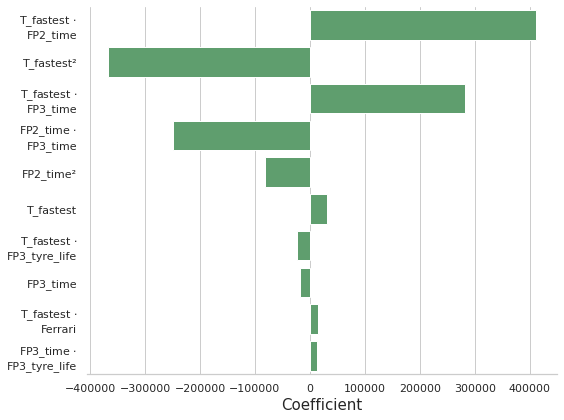

In [61]:
eval_dict[("QuadReg", 8)]["coefs"]["abs_importance"] = abs(eval_dict[("QuadReg", 8)]["coefs"]["Coefficient importance"])
imp_df = eval_dict[("QuadReg", 8)]["coefs"].sort_values(by=["abs_importance"], ascending=False).head(10)

imp_df = imp_df.sort_values(by=["abs_importance"], ascending=False)
imp_df = imp_df.drop(["abs_importance"], axis=1)


sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(8,6))

g = sns.barplot(x="Coefficient importance", y= imp_df.index, data = imp_df, color ="g")
plt.xlabel('Coefficient', fontsize=15)

yvalues = ["T_fastest $\cdot$ \nFP2_time", "T_fastest²", "T_fastest $\cdot$\nFP3_time",
           "FP2_time $\cdot$\nFP3_time", "FP2_time²",
          "T_fastest", "T_fastest $\cdot$\nFP3_tyre_life", "FP3_time", "T_fastest $\cdot$\nFerrari", 
           "FP3_time $\cdot$\nFP3_tyre_life"]

plt.yticks(np.arange(10), yvalues, fontsize=11)
# remove all borders except bottom
sns.despine(top=True,
            right=True,
            left=True,
            bottom=False)

plt.tight_layout()
plt.savefig('QR_FeatImportance.pdf', dpi=1000)
plt.show()
        

In [67]:
print("Num Teams", len(team_list))
print("Num Drivers", len(driver_list))
print("Num Tracks", len(track_list))
print(team_list)
print(driver_list)
print(track_list)
print(eval_dict[("LinReg",9)]["mod_r2"])

Num Teams 11
Num Drivers 33
Num Tracks 31
['McLaren' 'Red Bull' 'Ferrari' 'Haas' 'Alfa Romeo' 'AlphaTauri'
 'Aston Martin' 'Williams' 'Alpine' 'Mercedes' None]
['VAN' 'RIC' 'VET' 'RAI' 'GRO' 'ERI' 'GAS' 'PER' 'ALO' 'LEC' 'STR' 'MAG'
 'HUL' 'HAR' 'OCO' 'VER' 'SIR' 'HAM' 'SAI' 'BOT' 'NOR' 'ALB' 'KVY' 'RUS'
 'KUB' 'GIO' 'LAT' 'FIT' 'AIT' 'MAZ' 'TSU' 'MSC' nan]
['Melbourne' 'Bahrain' 'Shanghai' 'Baku' 'Barcelona' 'Monaco' 'Montreal'
 'Le Castellet' 'Spielberg' 'Silverstone' 'Hockenheim' 'Mogyorod'
 'Spa-Francorchamps' 'Monza' 'Singapore' 'Sochi' 'Suzuka' 'Austin'
 'Mexico City' 'Sao Paulo' 'Abu Dhabi' 'Mugello' 'Nürburg' 'Portimao'
 'Istanbul' 'Bahrain Short' 'Imola' 'Zandvoort' 'Lusail' 'Jeddah'
 'Abu Dhabi 2']
-2.768649852744639e+25
